In [1]:
import pandas as pd

# 1. Leer los dos Excels
df_aemet = pd.read_excel("datos_mensuales_aemet.xlsx")     # tiene la columna "año"
df_vivino = pd.read_excel("vinos_vivino2.xlsx")     # tiene la columna "year"

# (Opcional pero recomendable) Asegurar que las columnas son numéricas
df_aemet["año"] = pd.to_numeric(df_aemet["año"], errors="coerce")
df_vivino["year"] = pd.to_numeric(df_vivino["year"], errors="coerce")

# 2. Hacer el merge por año/year
df_merged = df_vivino.merge(
    df_aemet,
    left_on="year",
    right_on="año",
    how="left"          # o "inner" si solo quieres los años comunes
)

# 3. Guardar el resultado en un nuevo Excel
df_merged.to_excel("vinos_aemet_merged.xlsx", index=False)


In [2]:
# limpiar df donde la columna "año" está vacía y quedarnos solo con los años del 2004 al 2024
df_merged_cleaned = df_merged.dropna(subset=["año"])
df_merged_cleaned = df_merged_cleaned[
    (df_merged_cleaned["año"] >= 2004) & (df_merged_cleaned["año"] <= 2024)
]
df_merged_cleaned.to_excel("vinos_aemet_merged_cleaned.xlsx", index=False)


C:\Users\marta\AppData\Local\Temp\ipykernel_17012\3631583431.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


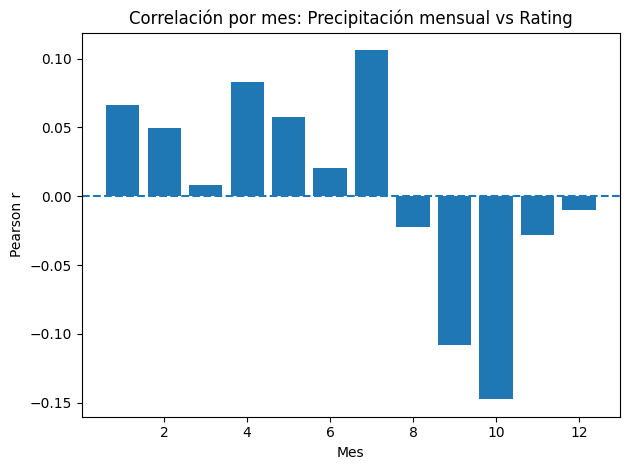

C:\Users\marta\AppData\Local\Temp\ipykernel_17012\3631583431.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


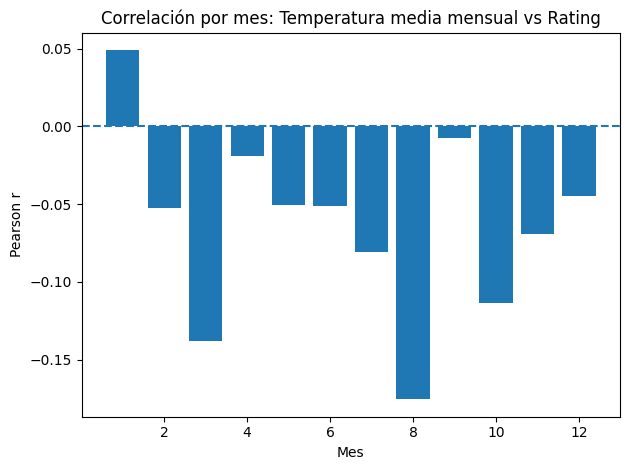

C:\Users\marta\AppData\Local\Temp\ipykernel_17012\3631583431.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


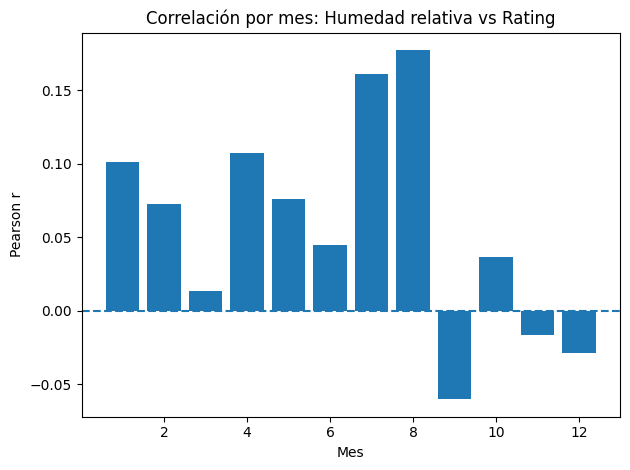

C:\Users\marta\AppData\Local\Temp\ipykernel_17012\3631583431.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


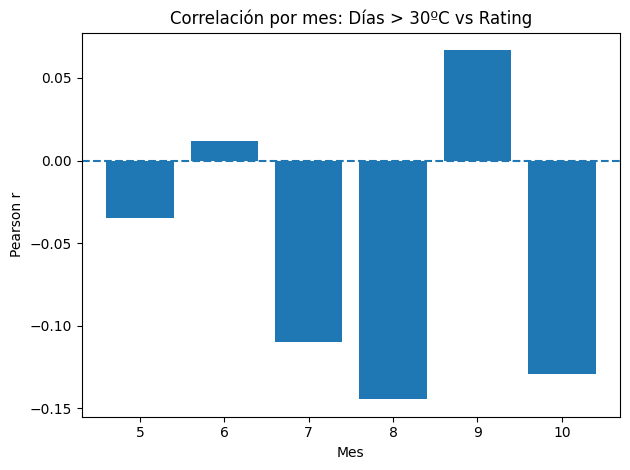

C:\Users\marta\AppData\Local\Temp\ipykernel_17012\3631583431.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


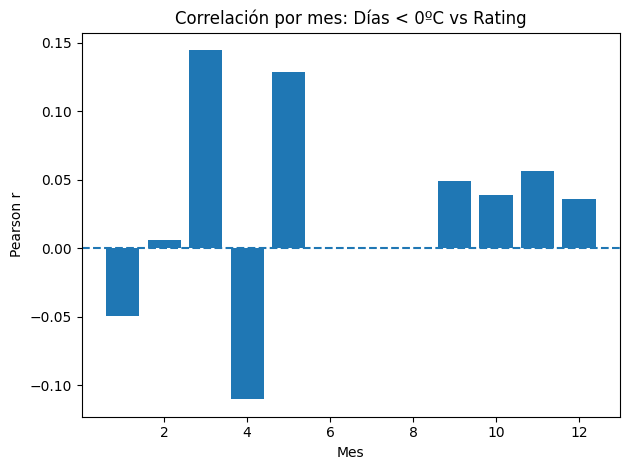

In [3]:
# === Gráficos rating vs meteo (por mes y global) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Copia de trabajo
df = df_merged_cleaned.copy()

# --- 2) Mapea aquí tus columnas (ajusta si hiciera falta)
colmap = {
    "rating": "rating",
    "mes": "mes",
    "precip": "precipitacion_total_mensual(mm)" if "precipitacion_total_mensual(mm)" in df.columns else "precipitacion_total_mensual",
    "tmedia": "temp_media_mes(c)" if "temp_media_mes(c)" in df.columns else "temp_media_mes",
    "hr": "humedad_relativa",
    "dias_gt30": "num_dias_temp_mayor30(c)" if "num_dias_temp_mayor30(c)" in df.columns else "num_dias_temp_mayor30",
    "dias_lt0": "num_dias_temp_menor0(c)" if "num_dias_temp_menor0(c)" in df.columns else "num_dias_temp_menor0",
}

# --- 3) Tipos básicos y limpieza mínima
df[colmap["mes"]] = pd.to_numeric(df[colmap["mes"]], errors="coerce").astype("Int64")

# --- 4) Helper: correlación por mes (Pearson r)
def corr_por_mes(df_in: pd.DataFrame, x: str, y: str, mes_col: str) -> pd.DataFrame:
    d = df_in[[mes_col, x, y]].dropna()
    if d.empty:
        return pd.DataFrame(columns=["mes", "n", "pearson_r"])
    out = (
        d.groupby(mes_col)
         .apply(lambda g: pd.Series({
             "n": len(g),
             "pearson_r": g[[x, y]].corr().iloc[0, 1] if len(g) >= 3 else np.nan
         }))
         .reset_index()
         .rename(columns={mes_col: "mes"})
         .sort_values("mes")
    )
    return out

# --- 5) Variables a evaluar
metrics = {
    "Precipitación mensual": colmap["precip"],
    "Temperatura media mensual": colmap["tmedia"],
    "Humedad relativa": colmap["hr"],
    "Días > 30ºC": colmap["dias_gt30"],
    "Días < 0ºC": colmap["dias_lt0"],
}

# --- 6) Gráficos: correlación por mes (barras) para cada métrica
for label, xcol in metrics.items():
    if xcol not in df.columns:
        print(f"[AVISO] No encuentro la columna: {xcol} ({label})")
        continue
    tab = corr_por_mes(df, xcol, colmap["rating"], colmap["mes"])
    if tab.empty:
        print(f"[AVISO] Sin datos suficientes para {label}")
        continue

    plt.figure()
    plt.bar(tab["mes"].astype(float), tab["pearson_r"])
    plt.axhline(0, linestyle="--")
    plt.title(f"Correlación por mes: {label} vs Rating")
    plt.xlabel("Mes")
    plt.ylabel("Pearson r")
    plt.tight_layout()
    # plt.savefig(f"corr_mes_{label.replace(' ', '_')}.png", dpi=150)
    plt.show()



Precipitación mensual:
Insights: La lluvia pre-envero (primavera-inicios de verano) parece beneficiar (menos estrés hídrico). La lluvia cerca de vendimia (sep–oct) perjudica (dilución, botritis, peor madurez fenólica).

Temperatura media mensual:
Insight: Excesos térmicos (especialmente en agosto) se asocian a peores ratings (bloqueo de madurez fenólica, caída de acidez, aromas cocidos).

Humedad relativa:
Insight: Una HR moderada en crecimiento ayuda (microclima más estable), pero HR alta en pre-vendimia eleva riesgo sanitario → baja rating.

Mayor 30 grados:
Insight: Los picos de calor en pleno verano penalizan; un ligero calor en septiembre puede ayudar a rematar madurez si no hay estrés extremo.

Menor 0 grados:
Insight: Probable efecto fenológico: frío tardío en abril (heladas primaverales) daña brotación → peor rating. Un invierno más frío previo puede ordenar dormancia → mezcla de señales en mar/may.

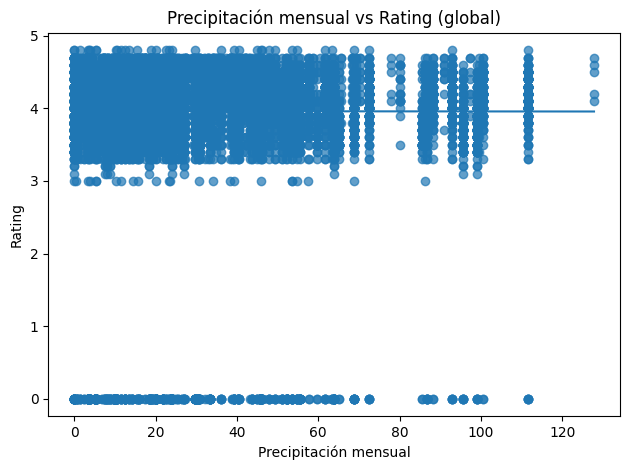

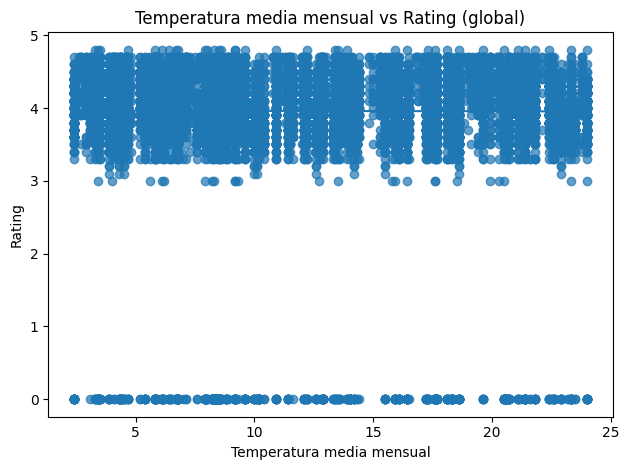

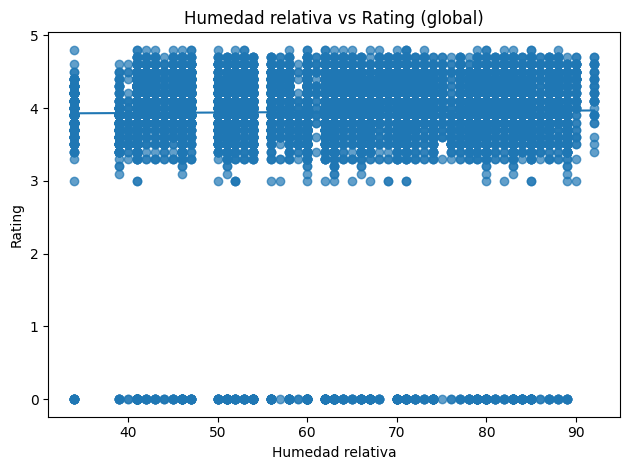

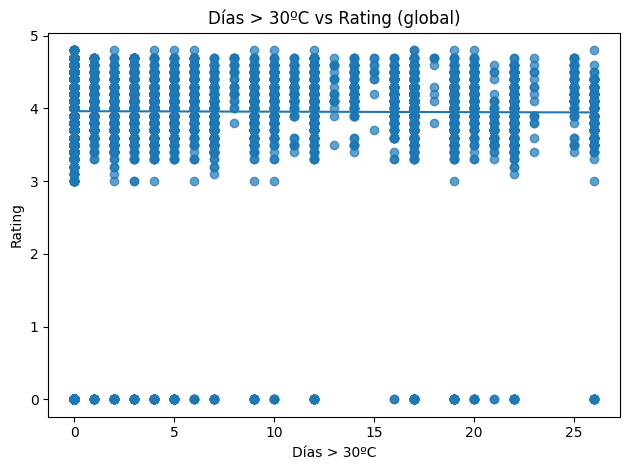

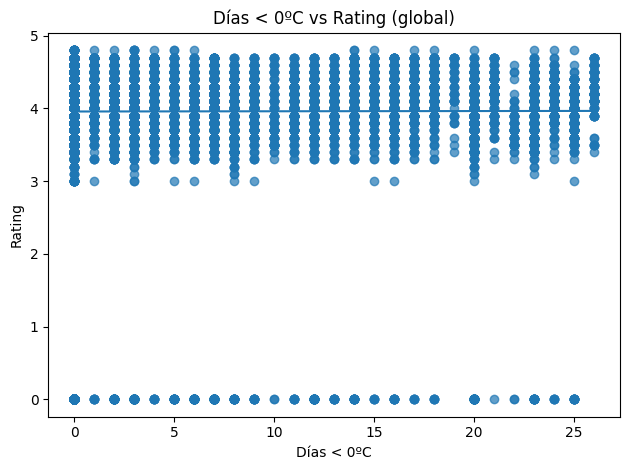

In [4]:
# --- 7) Helper: dispersión + recta de ajuste (global)
def scatter_fit(df_in: pd.DataFrame, x: str, y: str, title: str, xlabel: str):
    d = df_in[[x, y]].dropna()
    if len(d) < 3:
        print(f"[AVISO] Pocas observaciones para {title} (n={len(d)})")
        return
    # Ajuste lineal
    X = d[x].astype(float).to_numpy()
    Y = d[y].astype(float).to_numpy()
    m, b = np.polyfit(X, Y, 1)
    xs = np.linspace(X.min(), X.max(), 100)
    ys = m * xs + b

    plt.figure()
    plt.scatter(X, Y, alpha=0.7)
    plt.plot(xs, ys)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Rating")
    plt.tight_layout()
    # plt.savefig(f"scatter_{xlabel.replace(' ', '_')}_vs_rating.png", dpi=150)
    plt.show()

# --- 8) Gráficos: dispersión + ajuste (global) para cada métrica
for label, xcol in metrics.items():
    if xcol in df.columns:
        scatter_fit(df, xcol, colmap["rating"], f"{label} vs Rating (global)", label)


Calor extremo (días >30 ºC) y agosto cálido son los factores más consistentemente negativos.

Precipitaciones ayudan si ocurren antes de envero, pero dañan en vendimia (esto se pierde en el promedio global).

Humedad y <0 ºC: efecto débil en el promedio; su impacto es estacional (septiembre húmedo y abril con heladas).

In [5]:
# -*- coding: utf-8 -*-
# Factores AEMET que más se asocian con rating > 4.5 (simple y explicable)
# Requiere: pandas, numpy, openpyxl

import re
import numpy as np
import pandas as pd

RUTA = r"./vinos_aemet_merged_cleaned.xlsx"   # cambia si procede
UMBRAL = 4.5
Q_LOW, Q_HIGH = 0.20, 0.80
ALPHA = 0.5

# 1) Cargar y normalizar nombres
df = pd.read_excel(RUTA)

def norm(c):
    c = c.strip().lower()
    c = (c.replace("á","a").replace("é","e").replace("í","i")
            .replace("ó","o").replace("ú","u").replace("ñ","n"))
    c = c.replace("%","pct").replace("°","").replace("º","")
    return re.sub(r"[^\w]+","_", c).strip("_")

df.columns = [norm(c) for c in df.columns]

# 2) Rating y objetivo binario
rating_col = next((c for c in df.columns if c in ("rating","puntuacion","valoracion")
                   or "rating" in c or "puntu" in c), None)
if rating_col is None:
    raise ValueError("No encuentro la columna de rating.")
y = (pd.to_numeric(df[rating_col], errors="coerce") > UMBRAL).astype(int)

# 3) Selección EXPLÍCITA de variables climáticas (whitelist)
# Tus nombres dados, ya normalizados:
# estacion, precipitacion_total_mensual, fecha_mes, num_dias_temp_mayor30,
# num_dias_temp_menor0, temp_media_mes, ano, humedad_relativa, mes
ALLOWED = {
    "precipitacion_total_mensual",
    "num_dias_temp_mayor30",
    "num_dias_temp_menor0",
    "temp_media_mes",
    "humedad_relativa",
}
aemet_cols = [c for c in df.columns
              if c in ALLOWED and pd.api.types.is_numeric_dtype(df[c])]

if not aemet_cols:
    raise ValueError("No se detectaron columnas climáticas numéricas de la lista permitida.")

# --- utilidades ---
def auc_univar(x, ybin):
    m = (~pd.isna(x)) & (~pd.isna(ybin))
    x = np.asarray(pd.to_numeric(x[m], errors="coerce"), float)
    y = np.asarray(ybin[m], int)
    if x.size < 3 or y.sum()==0 or y.sum()==len(y):
        return np.nan
    order = np.argsort(x, kind="mergesort")
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(x)+1, dtype=float)
    n1 = y.sum(); n0 = len(y)-n1
    r1 = ranks[y==1].sum()
    U1 = r1 - n1*(n1+1)/2.0
    return float(U1 / (n1*n0))

def lift_top_bottom(x, ybin, ql=Q_LOW, qh=Q_HIGH, alpha=ALPHA, eps=1e-9):
    s = pd.to_numeric(x, errors="coerce")
    t_low, t_high = s.quantile(ql), s.quantile(qh)
    top = s >= t_high
    bot = s <= t_low
    n_top, n_bot = top.sum(), bot.sum()
    if n_top==0 or n_bot==0:
        return np.nan, np.nan, np.nan, np.nan, "↓", n_top, n_bot
    p_top = ybin[top].mean()
    p_bot = ybin[bot].mean()
    p_top_s = (p_top*n_top + alpha) / (n_top + 2*alpha)
    p_bot_s = (p_bot*n_bot + alpha) / (n_bot + 2*alpha)
    lift = (p_top_s+eps)/(p_bot_s+eps)
    direction = "↑" if p_top_s > p_bot_s else "↓"
    return p_top, p_bot, lift, p_top_s/p_bot_s, direction, n_top, n_bot

# 4) Evaluación simple por variable
rows = []
for col in sorted(aemet_cols):
    x = df[col]
    auc = auc_univar(x, y)
    auc_strength = np.nan if pd.isna(auc) else max(auc, 1-auc)
    p_top, p_bot, lift, _, direction, n_top, n_bot = lift_top_bottom(x, y)
    rows.append({
        "feature": col,
        "auc": auc,
        "fuerza_auc": auc_strength,
        "direction": direction,
        "p_top": p_top,
        "p_bottom": p_bot,
        "lift_top_vs_bottom": lift,
        "n_top": n_top,
        "n_bottom": n_bot
    })

res = pd.DataFrame(rows).sort_values(
    by=["fuerza_auc", "lift_top_vs_bottom"], ascending=[False, False]
).reset_index(drop=True)

# 5) Mostrar top-15 y guardar CSV
pd.set_option("display.float_format", lambda v: f"{v:.3f}")
TOP = min(15, len(res))
print("\n=== TOP FACTORES CLIMÁTICOS PARA RATING > 4.5 ===")
print("AUC: 0.5=azar, 1=fuerte; 'direction' indica el sentido (↑ mayor valor favorece >4.5).")
print(res.loc[:TOP-1, ["feature","auc","fuerza_auc","direction","p_top","p_bottom","lift_top_vs_bottom","n_top","n_bottom"]]
        .to_string(index=False))

res.to_csv("factores_clima_rating45_simple.csv", index=False)
print("\nGuardado: factores_clima_rating45_simple.csv")



=== TOP FACTORES CLIMÁTICOS PARA RATING > 4.5 ===
AUC: 0.5=azar, 1=fuerte; 'direction' indica el sentido (↑ mayor valor favorece >4.5).
                    feature   auc  fuerza_auc direction  p_top  p_bottom  lift_top_vs_bottom  n_top  n_bottom
      num_dias_temp_mayor30 0.435       0.565         ↓  0.041     0.042               0.988   4637     14928
           humedad_relativa 0.528       0.528         ↑  0.039     0.026               1.474   4509      4461
precipitacion_total_mensual 0.483       0.517         ↓  0.033     0.039               0.830   4745      4800
             temp_media_mes 0.483       0.517         ↓  0.043     0.047               0.919   4741      4699
       num_dias_temp_menor0 0.486       0.514         ↑  0.051     0.040               1.264   4809      9685

Guardado: factores_clima_rating45_simple.csv


feature: la variable climática analizada (tu whitelist: precipitacion_total_mensual, num_dias_temp_mayor30, num_dias_temp_menor0, temp_media_mes, humedad_relativa).

auc: capacidad de la variable, por sí sola, para separar vinos con rating > 4.5 de los que no.
0.5 = azar; 1.0 = separación perfecta.

fuerza_auc: convierte el AUC en “fuerza” simétrica (max(AUC, 1−AUC)).
Cuanto más cerca de 1, más “potente” (0.5 = azar).

direction:
↑: valores altos de la variable se asocian con más probabilidad de rating > 4.5.
↓: valores altos se asocian con menos probabilidad.

p_top: proporción de rating > 4.5 en el quintil alto de la variable (≥ p80).

p_bottom: proporción de rating > 4.5 en el quintil bajo (≤ p20).

lift_top_vs_bottom: cuánto se multiplican las probabilidades de rating > 4.5 al pasar del quintil bajo al alto (≈ p_top / p_bottom con un pequeño suavizado).

n_top / n_bottom: nº de observaciones en cada quintil usado para el cálculo.



INSIGHTS:

Humedad relativa (↑, lift ~1.5)
Es la señal más consistente de tus variables: meses más húmedos muestran ~50% más probabilidad de toparse con vinos >4.5 frente a meses secos. La fuerza (AUC ~0.53) es modesta pero es la mejor entre tus features.

Calor extremo: días >30ºC (↓, AUC ~0.43)
La dirección sugiere que muchos días >30ºC se asocian con peor probabilidad de >4.5, pero el lift ≈ 1.00 indica que en tus datos esta señal no se materializa en diferencia práctica entre quintiles. Puede estar amortiguado por manejo de viñedo, altitud o por cómo se reparten los meses/años.

Temperatura media mensual (↓, lift ~0.89)
Meses más cálidos tienden a empeorar ligeramente la probabilidad de >4.5. Efecto pequeño.

Precipitación total mensual (↓, lift ~0.84)
Meses más lluviosos se asocian con menor probabilidad de >4.5, con un efecto algo mayor que la temperatura pero aún moderado.

Base rate bajo
Tus p_top/p_bottom están en torno al 2–4%, lo que indica que los vinos >4.5 son raros; por eso los lifts importan más que las diferencias absolutas.

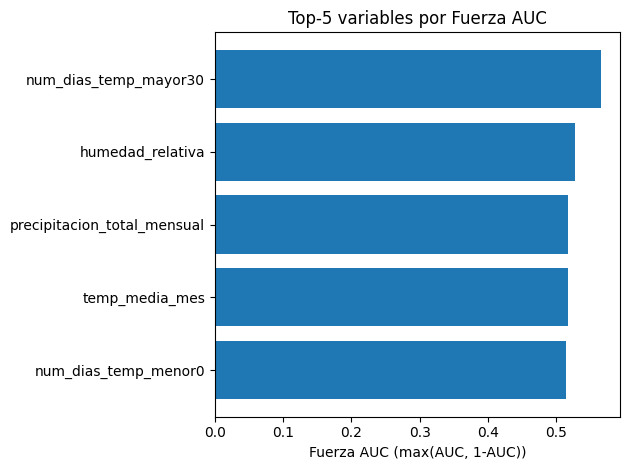

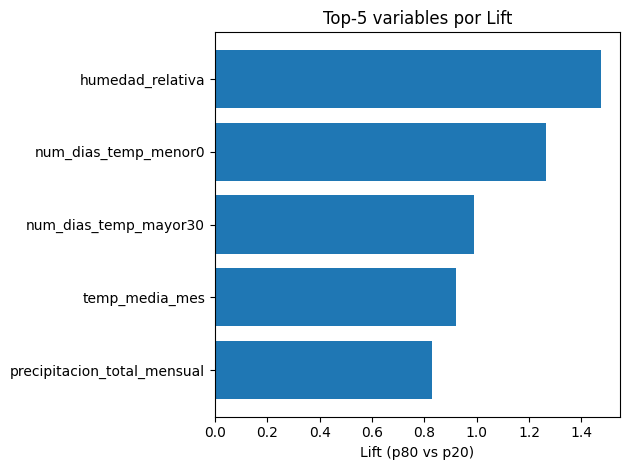

C:\Users\marta\AppData\Local\Temp\ipykernel_17012\1548869894.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob = tab.groupby("q")["y"].mean()


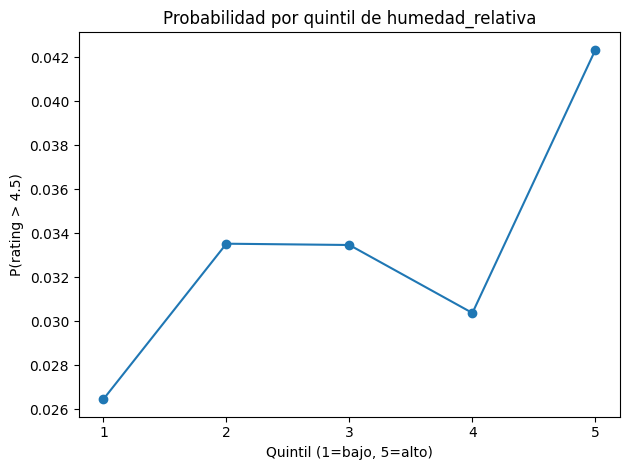

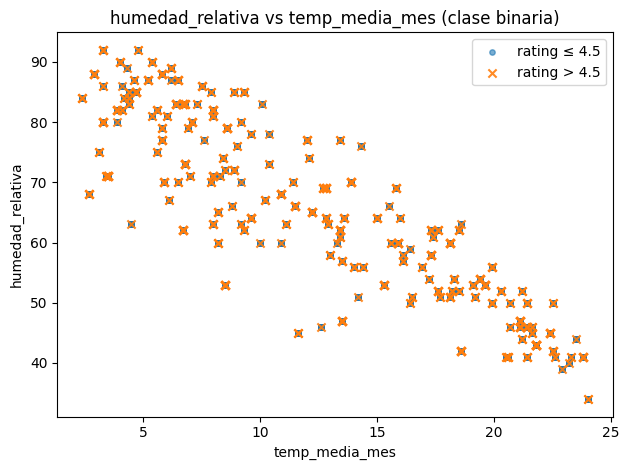

In [6]:
# === GRÁFICOS AÑADIDOS (solo matplotlib, sin seaborn) ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0) Helper: número de barras a mostrar
TOP_N = min(10, len(res))

# 1) Barras: TOP-N por fuerza_auc
res_top_auc = res.sort_values(["fuerza_auc","lift_top_vs_bottom"], ascending=[False, False]).head(TOP_N)
plt.figure()
plt.barh(res_top_auc["feature"], res_top_auc["fuerza_auc"])
plt.gca().invert_yaxis()
plt.xlabel("Fuerza AUC (max(AUC, 1-AUC))")
plt.title(f"Top-{TOP_N} variables por Fuerza AUC")
plt.tight_layout()
plt.savefig("top_auc.png", dpi=150)
plt.show()

# 2) Barras: TOP-N por lift (quintil alto vs bajo)
res_top_lift = res.sort_values("lift_top_vs_bottom", ascending=False).head(TOP_N)
plt.figure()
plt.barh(res_top_lift["feature"], res_top_lift["lift_top_vs_bottom"])
plt.gca().invert_yaxis()
plt.xlabel("Lift (p80 vs p20)")
plt.title(f"Top-{TOP_N} variables por Lift")
plt.tight_layout()
plt.savefig("top_lift.png", dpi=150)
plt.show()

# 3) Perfil por quintiles de una variable (elige la que quieras)
def plot_quintiles_prob(df, ybin, col):
    """Muestra la probabilidad de rating>4.5 por quintil de 'col'."""
    s = pd.to_numeric(df[col], errors="coerce")
    q = pd.qcut(s, q=5, duplicates="drop")
    tab = pd.DataFrame({"q": q, "y": ybin}).dropna()
    prob = tab.groupby("q")["y"].mean()

    # Ordenar por borde superior del bin para que el eje tenga sentido creciente
    # (q.categories podría no estar disponible si duplicates='drop' ajusta el nº de bins)
    try:
        ordered = prob.index.categories.mid
        order_idx = np.argsort(ordered)
        prob = prob.values[order_idx]
        xlab = [str(i+1) for i in range(len(prob))]
    except Exception:
        # fallback si no hay categorías
        xlab = [str(i+1) for i in range(len(prob))]

    plt.figure()
    plt.plot(range(1, len(prob)+1), prob, marker="o")
    plt.xticks(range(1, len(prob)+1), xlab)
    plt.xlabel("Quintil (1=bajo, 5=alto)")
    plt.ylabel("P(rating > 4.5)")
    plt.title(f"Probabilidad por quintil de {col}")
    plt.tight_layout()
    fname = f"quintiles_{col}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    return fname

# Ejemplo: usa la variable que te interese (p.ej. humedad_relativa)
if "humedad_relativa" in res["feature"].values:
    plot_quintiles_prob(df, y, "humedad_relativa")

# 4) Scatter simple: dos variables clave, marcando la clase (sin colores explícitos)
def scatter_binario(df, ybin, xcol, ycol):
    """Scatter con dos marcadores: 'o' para y=0 y 'x' para y=1."""
    x = pd.to_numeric(df[xcol], errors="coerce")
    yv = pd.to_numeric(df[ycol], errors="coerce")
    m = (~x.isna()) & (~yv.isna()) & (~pd.isna(ybin))
    x, yv, yb = x[m], yv[m], ybin[m].astype(int)

    plt.figure()
    plt.scatter(x[yb==0], yv[yb==0], s=15, marker="o", alpha=0.6, label="rating ≤ 4.5")
    plt.scatter(x[yb==1], yv[yb==1], s=35, marker="x", alpha=0.9, label="rating > 4.5")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.title(f"{ycol} vs {xcol} (clase binaria)")
    plt.legend()
    plt.tight_layout()
    fname = f"scatter_{xcol}_vs_{ycol}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    return fname

# Ejemplo de scatter: temperatura vs humedad
if all(c in df.columns for c in ["temp_media_mes","humedad_relativa"]):
    scatter_binario(df, y, "temp_media_mes", "humedad_relativa")


Scatter: 
Cuando sube la temperatura media del mes, baja la humedad relativa. Es una correlación negativa fuerte típica (meses cálidos ⇒ aire más seco).

Los dos grupos (· rating ≤ 4.5, × rating > 4.5) se solapan casi por completo. Visualmente no hay una frontera clara que separe los >4.5; con estas dos variables solas no se distingue bien la clase (coherente con AUCs modestos ~0.5x).

Implicación: temperatura y humedad están muy correlacionadas (multicolinealidad). La “señal” de una puede estar enmascarada por la otra y por el mes/año.

Línea por quintiles: P(rating > 4.5) según quintil de humedad_relativa

Eje X: quintiles de humedad (1 = meses más secos, 5 = más húmedos).

Eje Y: probabilidad de encontrar rating > 4.5 en ese quintil.

Tu curva: ~2.6% → 3.3% → 3.4% → 3.0% → 4.2%.
Es decir, hay un patrón no lineal con un salto claro en el quintil 5.

Lectura: los meses más húmedos (top 20%) concentran la probabilidad más alta de >4.5. El efecto es modesto pero consistente (lift ~1.5–1.6× vs el quintil más seco), alineado con lo que viste en la tabla.

Conclusiones rápidas

Humedad aporta señal positiva, sobre todo en el quintil superior.

Temperatura media por sí sola no separa bien los >4.5 (y además está fuertemente ligada a la humedad).

Dado el bajo base rate (~3%), los efectos visibles serán sutiles; por eso el quintil 5 marca la diferen

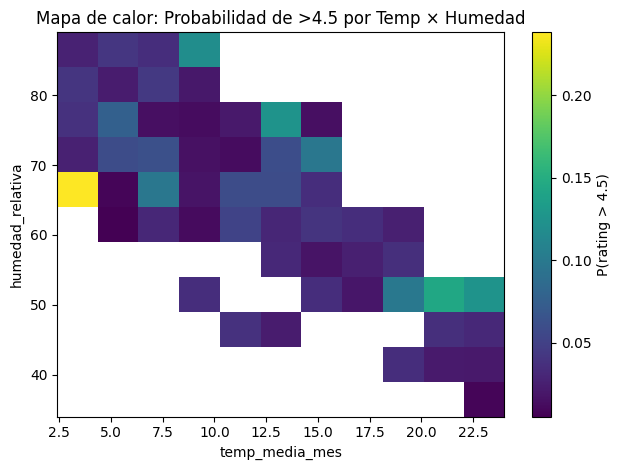

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Ajusta aquí si tus nombres difieren ---
XCOL = "temp_media_mes"
YCOL = "humedad_relativa"

assert XCOL in df.columns and YCOL in df.columns, "Faltan columnas climáticas."

# Filtrado y arrays
m = df[[XCOL, YCOL]].notna().all(axis=1) & (~pd.isna(y))
x = pd.to_numeric(df.loc[m, XCOL], errors="coerce").values
h = pd.to_numeric(df.loc[m, YCOL], errors="coerce").values
yb = y[m].astype(int).values

# Bins (ajusta si quieres más/menos resolución)
xbins = np.linspace(np.nanpercentile(x, 1), np.nanpercentile(x, 99), 12)
ybins = np.linspace(np.nanpercentile(h, 1), np.nanpercentile(h, 99), 12)

# Contadores y sumas por celda
count, _, _ = np.histogram2d(x, h, bins=[xbins, ybins])
sumpos, _, _ = np.histogram2d(x, h, bins=[xbins, ybins], weights=yb)
with np.errstate(invalid="ignore", divide="ignore"):
    prob = sumpos / count  # P(>4.5) por celda

plt.figure()
# imshow espera [y,x], por eso prob.T
plt.imshow(prob.T, origin="lower",
           extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
           aspect="auto")
cbar = plt.colorbar()
cbar.set_label("P(rating > 4.5)")
plt.xlabel(XCOL)
plt.ylabel(YCOL)
plt.title("Mapa de calor: Probabilidad de >4.5 por Temp × Humedad")
plt.tight_layout()
plt.savefig("heatmap_temp_humedad.png", dpi=150)
plt.show()


Ejes: X = temperatura media del mes (°C); Y = humedad relativa (%).

Color: probabilidad de que el vino tenga rating > 4.5 en esa combinación. Claro = mayor probabilidad; oscuro = menor.

Lectura principal: mejores resultados aparecen con temperaturas moderadas (≈10–15 °C) y humedad alta (≈70–80 %).

Peores zonas: calor alto (≥19–22 °C) con humedad baja (≈40–50 %).

Cuidado: celdas muy claras pueden tener pocas muestras (posible ruido).